<IPython.core.display.Javascript object>


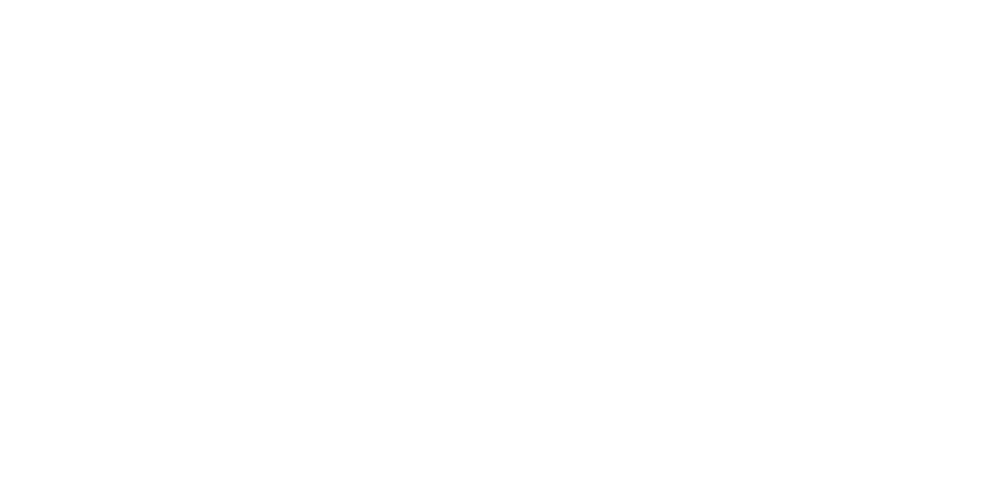

Center of mass coordinates:  215.9862842892768


<IPython.core.display.Javascript object>


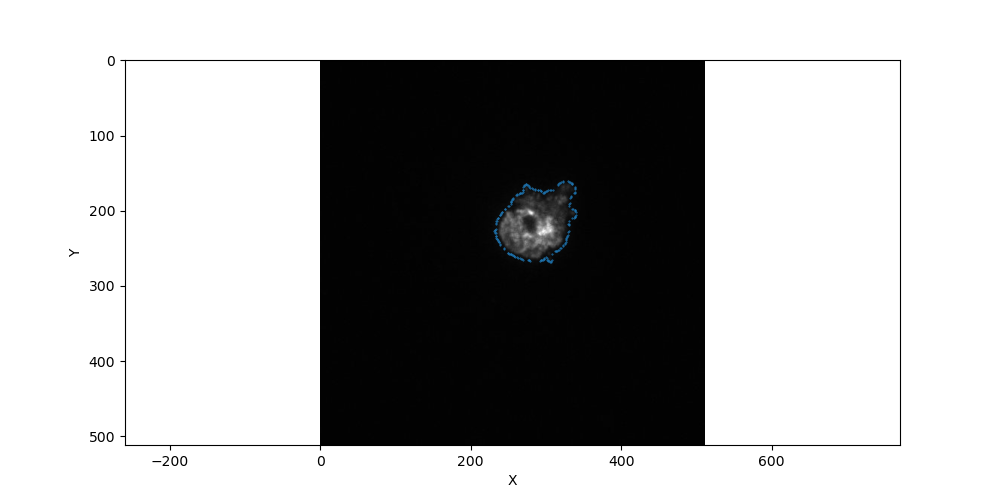

189
area_wt 3.05938720703125


In [1]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

from collections import defaultdict
import PIL
from sklearn.cluster import KMeans
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import factorial
from scipy.stats import poisson
from itertools import chain
from scipy.special import i0




from tqdm import tqdm
import scipy.cluster.hierarchy as hcluster
from scipy import ndimage
# change the following to %matplotlib notebook for interactive plotting
%matplotlib notebook
from scipy.signal import find_peaks
# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import cv2
import pims
import trackpy as tp

## import images
def count_ones(matrix):
    count = 0
    tot=0
    for row in matrix:
        for element in row:
            tot+=1
            if element == 1:
                count += 1
    return (count/tot)*100



def subtract_with_previous(lst):
    result = []
    for i in range(1, len(lst)):
        diff = np.abs(lst[i] - lst[i - 1])
        result.append(diff)
    return result

def find_deviation(file):
    @pims.pipeline
    def gray(image):
        return image[:, :, 1]  # Take just the green channel

    frames = pims.open(file)
    first_frame = frames[1]
    blurred_frame = cv2.GaussianBlur(first_frame, (5, 5),100)  # Applying Gaussian blur with kernel size (5, 5)
    threshold = 20  # Set desired threshold value

    binary_img = np.where(blurred_frame > threshold, 1,0)
       
    Area_initial = count_ones(binary_img)
    center_of_mass_initial = ndimage.measurements.center_of_mass(binary_img)
    Area_store=[]
    av_vec_store=[]
    r_cm_store=[]
    var_vector_store=[]
    cm_coordinates_x=[]
    cm_coordinates_y=[]
    for n in range(0,len(frames)):
        first_frame = frames[n]
        blurred_frame = cv2.GaussianBlur(first_frame, (5, 5),100)  # Applying Gaussian blur with kernel size (5, 5)
        threshold = 20  # Set desired threshold value

        binary_img = np.where(blurred_frame > threshold, 1,0)
        Area = count_ones(binary_img)
        Area_store.append(Area)
        
        %matplotlib notebook
        # Load the binary image
        image = binary_img
        image = cv2.convertScaleAbs(image)
        center_of_mass = ndimage.measurements.center_of_mass(binary_img)
        
        cm_coordinates_x.append(center_of_mass[0])
        cm_coordinates_y.append(center_of_mass[1])
        r_cm_store.append(np.sqrt(center_of_mass[0]**2+center_of_mass[1]**2))
        
        # Apply Canny edge detection
        edges = cv2.Canny(image, 0, 1)  # Adjust the thresholds as needed
       
        # Convert edge image to binary format
        edges = edges.astype(np.uint8)

        # Find contours of the edges
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Combine all edge coordinates into a single list
        edge_coordinates = []
        for contour in contours:
            contour_coordinates = []
            for point in contour:
                x, y = point[0]
                contour_coordinates.append((x, y))
            edge_coordinates.extend(contour_coordinates)

        # Convert edge_coordinates to a NumPy array
        edge_coordinates = np.array(edge_coordinates)
        coordinates = edge_coordinates
        coordinates = np.array(coordinates)

        # Calculate radial distance from the origin
        distances=[]
        for pos in edge_coordinates:
            r=np.sqrt((pos[0]-center_of_mass_initial[0])**2+(pos[1]-center_of_mass_initial[1])**2)
            distances.append(r)
        av_dist_time=np.mean(distances)
        
        # Print the radial distances
        #print(np.mean(distances))
        av_vec_store.append(np.mean(distances))
        var_time=[]
        for r in distances:
            var_time.append(np.abs(r-av_dist_time))
        
        var_vector_store.append(np.mean(var_time))
    
    difference = subtract_with_previous(av_vec_store)
    area_change= subtract_with_previous(Area_store)
    
    variance_change=subtract_with_previous(var_vector_store)
    cm_coord_change_x=subtract_with_previous(cm_coordinates_x)
    cm_coord_change_y=subtract_with_previous(cm_coordinates_y)
    ##r_cm_change= subtract_with_previous(r_cm_store)
    r_cm_change= [i**2+j**2 for i,j in zip(cm_coord_change_x,cm_coord_change_x)]
    Area_initial=1
    normalised_difference=[i/Area_initial for i in difference ]
    normalised_area_change=[i/Area_initial for i in  area_change]
    normalised_r_cm_change=[i/Area_initial for i in  r_cm_change]
    normalised_variance_change=[i/Area_initial for i in  variance_change]
    
    return normalised_difference,normalised_area_change,normalised_r_cm_change,normalised_variance_change



def smooth_list(lst, window_size):
    smoothed = []
    for i in range(len(lst)):
        window_start = max(0, i - window_size + 1)
        window_end = i + 1
        window_values = lst[window_start:window_end]
        window_average = sum(window_values) / len(window_values)
        smoothed.append(window_average)
    return smoothed


#def average_lists_by_label(A, B):
#    grouped_lists = defaultdict(list)
#    
#    for sublist, label in zip(A, B):
#        grouped_lists[label].append(sublist)
    
#    averaged_lists = {}
#    for label, sublists in grouped_lists.items():
#        averaged_lists[label] = [sum(elements) / len(elements) for elements in zip(*sublists)]
    
 #   return averaged_lists

def average_lists_by_label(A, B):
    grouped_lists = defaultdict(list)

    for sublist, label in zip(A, B):
        grouped_lists[label].append(sublist)

    averaged_lists = {}
    variances= {}
    for label, sublists in grouped_lists.items():
        averaged_lists[label] = [np.mean(elements) for elements in zip(*sublists)]
        variances[label] = [np.var(elements) for elements in zip(*sublists)]
        

    return  averaged_lists,variances

@pims.pipeline
def gray(image):
    return image[:, :, 1]  # Take just the green channel

frames = pims.open('30/*.jpg')

first_frame = frames[1]
blurred_frame = cv2.GaussianBlur(first_frame, (5, 5),100)  # Applying Gaussian blur with kernel size (5, 5)
threshold = 15  # Set your desired threshold value

binary_img = np.where(blurred_frame > threshold, 1,0)
plt.imshow(binary_img, cmap='gray')

plt.imshow(binary_img)
center_of_mass = ndimage.measurements.center_of_mass(binary_img)

# Print the center of mass
print("Center of mass coordinates: ", center_of_mass[0])

Area_WT = count_ones(binary_img)
%matplotlib notebook
# Load the binary image
image = binary_img
image = cv2.convertScaleAbs(image)

# Apply Canny edge detection
edges = cv2.Canny(image, 0, 1)  # Adjust the thresholds as needed

# Convert edge image to binary format
edges = edges.astype(np.uint8)

# Find contours of the edges
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Combine all edge coordinates into a single list
edge_coordinates = []
for contour in contours:
    contour_coordinates = []
    for point in contour:
        x, y = point[0]
        contour_coordinates.append((x, y))
    edge_coordinates.extend(contour_coordinates)
#print( edge_coordinates)
# Convert edge_coordinates to a NumPy array
edge_coordinates = np.array(edge_coordinates)
for pos in edge_coordinates:
    r=np.sqrt((pos[0]-center_of_mass[0])**2+(pos[1]-center_of_mass[1])**2)
    
# Plot the edge coordinates
plt.scatter(edge_coordinates[:, 0], edge_coordinates[:, 1],s=0.2)
print(len(edge_coordinates))
# Display the plot
plt.gca().invert_yaxis()
plt.axis('equal')
plt.xlabel('X')
plt.ylabel('Y')
plt.imshow(first_frame, cmap='gray')

plt.show()
print('area_wt',Area_WT)

In [2]:
#difference_wt=find_deviation('mouse wt 150117 actin/*.jpg')
difference_J=find_deviation('6/*.jpg')
difference_wt1=find_deviation('mouse wt 144651 actin/*.jpg')
difference_wasp1=find_deviation('43/*.jpg')
#difference_wasp2=find_deviation('44/*.jpg')
#difference_wasp3=find_deviation('45/*.jpg')

<IPython.core.display.Javascript object>


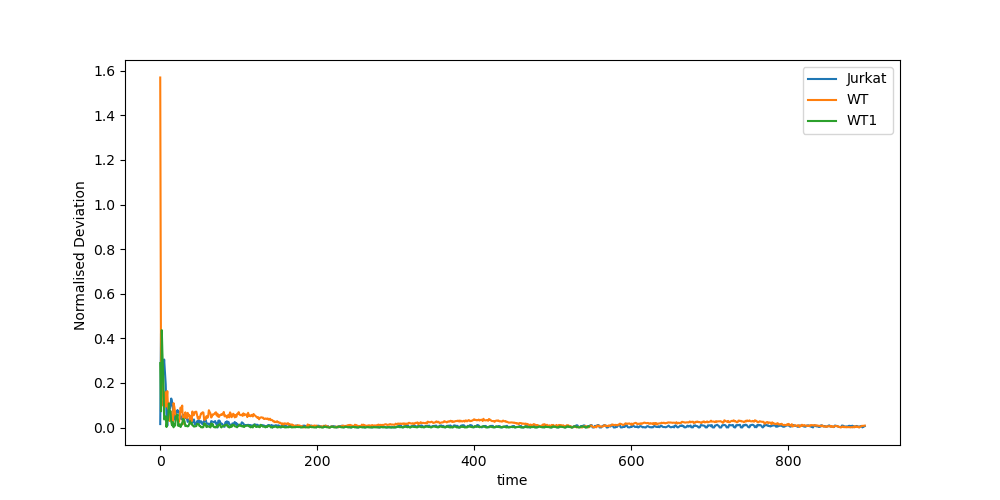

In [14]:

%matplotlib notebook




window_size =300
smoothed_difference_J =smooth_list(difference_J, window_size)

#smoothed_difference_wt = smooth_list(difference_wt, window_size)
smoothed_difference_wt1 = smooth_list(difference_wt1, window_size)
smoothed_difference_wasp1=smooth_list(difference_wasp1,window_size)
#smoothed_difference_wasp2=smooth_list(difference_wasp2,window_size)
#smoothed_difference_wasp3=smooth_list(difference_wasp3,window_size)
plt.plot(np.abs(smoothed_difference_J))
#plt.plot(smoothed_difference_wt)
plt.plot(np.abs(smoothed_difference_wt1))
plt.plot(np.abs(smoothed_difference_wasp1))
#plt.plot(smoothed_difference_wasp2)
#plt.plot(smoothed_difference_wasp3)
plt.ylabel('Normalised Deviation ')
plt.xlabel('time')
plt.legend(['Jurkat','WT','WT1','wasp1','wasp2','wasp3'])

100%|███████████████████████████████████████████| 24/24 [14:51<00:00, 37.16s/it]


<IPython.core.display.Javascript object>


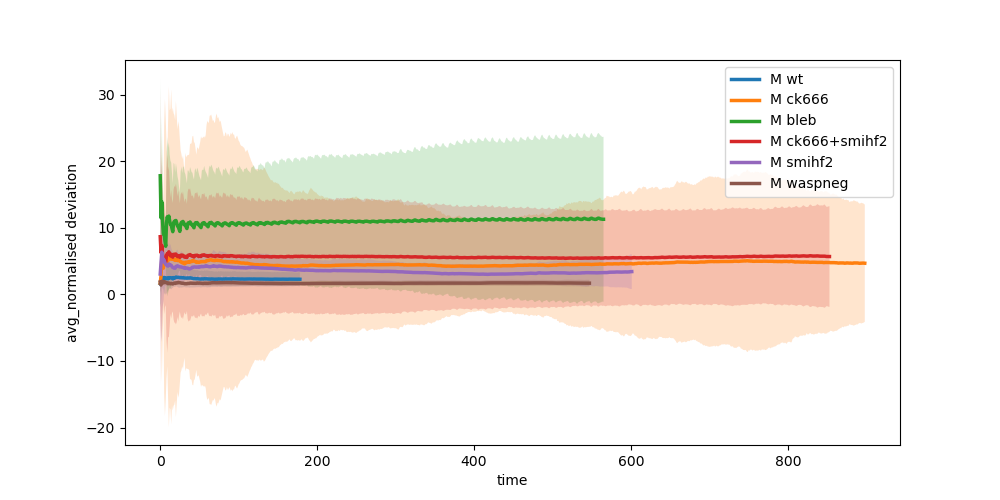

In [3]:
treatment=[]
difference_store=[]
area_time_store=[]
cm_time_store=[]
variance_time_store=[]
files=np.arange(1,48).tolist()
#files.remove(1)
#files.remove(3)
#files.remove(19)
files.remove(31)
files.remove(41)
files.remove(42)
for i in range(1,21):
    files.remove(i)
#for i in range(29,42):
    #files.remove(i)

    

for i in tqdm(files):
    #print(i)
    if i>=1 and i<= 7:
        treatment.append('J wt')
        
    elif i>=8 and i<=10:
        treatment.append('J ck666')
    elif i>=11 and i<=12:
        treatment.append('J bleb')
    elif i>=13 and i<=16:
        treatment.append('J smihf2')
    elif i>=17 and i<=20:
        treatment.append('J ck666+smihf2')
    elif i>=21 and i<=28:
        treatment.append('M wt')
    elif i>=29 and i<=32:
        treatment.append('M ck666')
    elif i>=33 and i<=34:
        treatment.append('M bleb')
    elif i>=35 and i<=37:
        treatment.append('M ck666+smihf2')
    elif i>=38 and i<=41:
        treatment.append('M smihf2')
    elif i>=42 and i<=47:
        treatment.append('M waspneg')
    
    
    window_size =300
    difference,area,cm,var=find_deviation('%d/*.jpg'%i)
    smoothed_difference =smooth_list(difference, window_size)
    smoothed_area =smooth_list(area, window_size)
    smoothed_cm =smooth_list(cm, window_size)
    smoothed_var =smooth_list(var, window_size)
    difference_store.append(smoothed_difference)
    area_time_store.append(smoothed_area)
    cm_time_store.append(smoothed_cm)
    variance_time_store.append(smoothed_var)
    
    
%matplotlib notebook

averaged_lists,var = average_lists_by_label(difference_store, treatment)

for (label, averaged_list) ,(label,var) in zip(averaged_lists.items(),var.items()) :
    x = range(len(averaged_list))
    y = np.array(averaged_list)
    error = np.array(var)

    plt.plot(x,y, linewidth=2.5, label=label)
    plt.fill_between(x, y - error, y + error, alpha=0.2)
    #plt.plot(averaged_list, label=label)
    

plt.legend()
plt.xlabel('time')
plt.ylabel('avg_normalised deviation')

plt.show()  

In [11]:
print(difference)

[0.12782777771245912, 0.04962286111623726, 0.6860175104849423, 0.40066304377876966, 0.09265759576134247, 0.4402818070007203, 0.22964556829304406, 0.05633714958878044, 0.4218733142426421, 0.19416054227402219, 0.25002824166173016, 0.4076051254608495, 0.15370896966530231, 0.22670175677789212, 0.37340483483244796, 0.07891251208699078, 0.001918179309197338, 0.8592410149821564, 0.6464135716807877, 0.17484068922452334, 0.9698502454254997, 0.48229248417649845, 0.2084329209194887, 0.630778261729839, 0.06179288686956094, 0.1912531523038289, 0.5307742993010117, 0.08091210950280003, 0.17442904359440278, 0.4538514027865147, 0.03238862623662243, 0.022848241290978098, 0.3035780504060657, 0.13994600504665022, 0.2306748817866634, 0.4874309246496917, 0.17573441749111948, 0.1913291230752504, 0.6931675220802649, 0.1753013284882088, 0.012769401289072137, 0.3369720845695349, 0.018505338626925733, 0.09820230230206031, 0.5415286386119615, 0.24963249832313822, 0.14378690208219455, 0.6066558119492681, 0.1542621

<IPython.core.display.Javascript object>


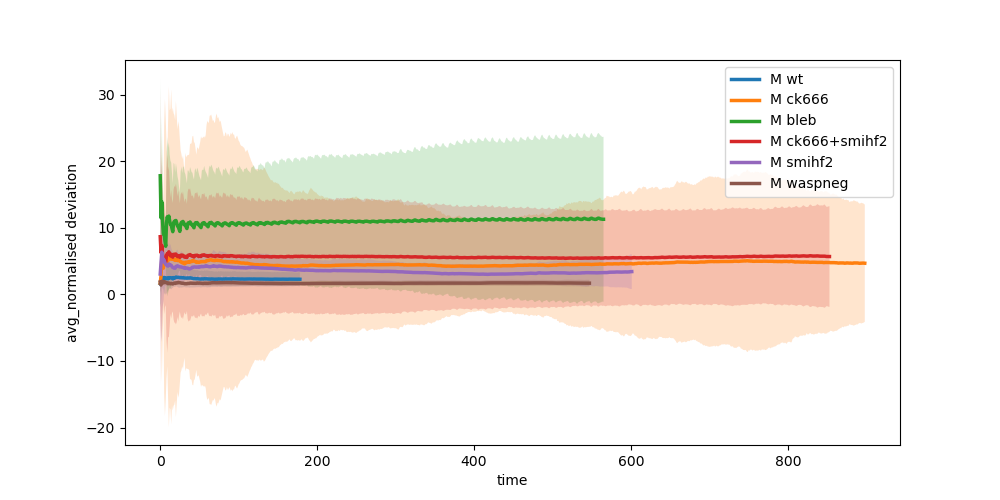

In [4]:
averaged_lists,var = average_lists_by_label(difference_store, treatment)
%matplotlib notebook
for (label, averaged_list) ,(label,var) in zip(averaged_lists.items(),var.items()) :
    x = range(len(averaged_list))
    y = np.array(averaged_list)
    error = np.array(var)

    plt.plot(x,y, linewidth=2.5, label=label)
    plt.fill_between(x, y - error, y + error, alpha=0.2)
    #plt.plot(averaged_list, label=label)
    

plt.legend()
plt.xlabel('time')
plt.ylabel('avg_normalised deviation')

plt.show()  

<IPython.core.display.Javascript object>


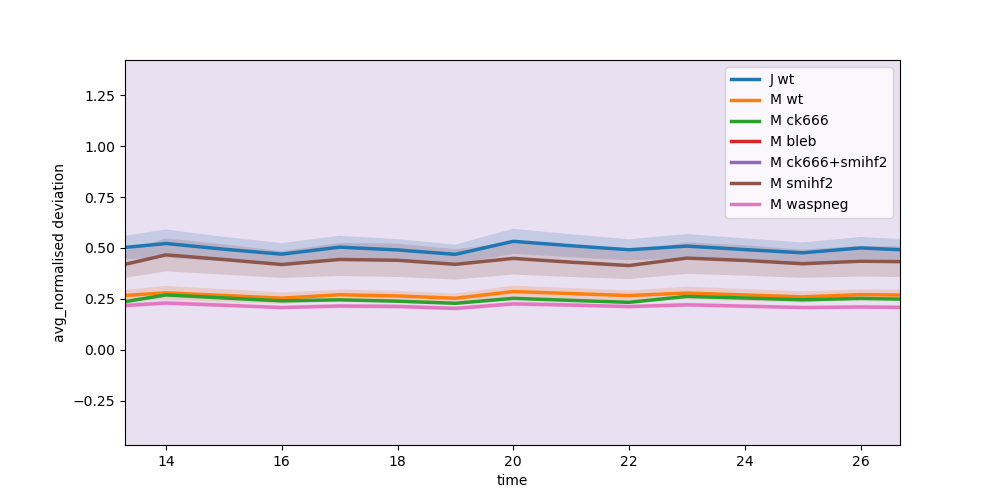

In [21]:
averaged_lists,var = average_lists_by_label(area_time_store, treatment)

%matplotlib notebook
for (label, averaged_list) ,(label,var) in zip(averaged_lists.items(),var.items()) :
    x = range(len(averaged_list))
    y = np.array(averaged_list)
    error = np.array(var)

    plt.plot(x,y, linewidth=2.5, label=label)
    plt.fill_between(x, y - error, y + error, alpha=0.2)
    #plt.plot(averaged_list, label=label)
    

plt.legend()
plt.xlabel('time')
plt.ylabel('avg_normalised deviation')

plt.show()  

<IPython.core.display.Javascript object>


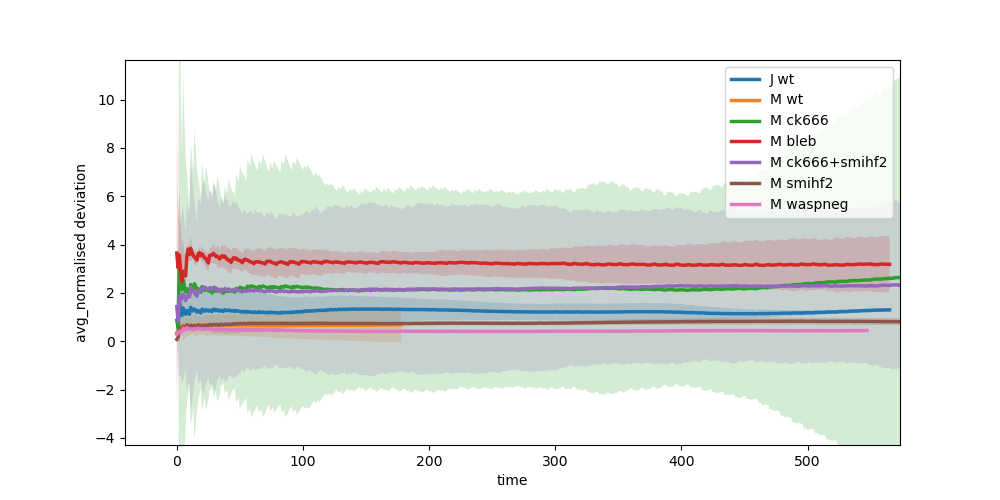

In [24]:
averaged_lists,var = average_lists_by_label(cm_time_store, treatment)

%matplotlib notebook
for (label, averaged_list) ,(label,var) in zip(averaged_lists.items(),var.items()) :
    x = range(len(averaged_list))
    y = np.array(averaged_list)
    error = np.array(var)

    plt.plot(x,y, linewidth=2.5, label=label)
    plt.fill_between(x, y - error, y + error, alpha=0.2)
    #plt.plot(averaged_list, label=label)
    

plt.legend()
plt.xlabel('time')
plt.ylabel('avg_normalised deviation')

plt.show()  

<IPython.core.display.Javascript object>


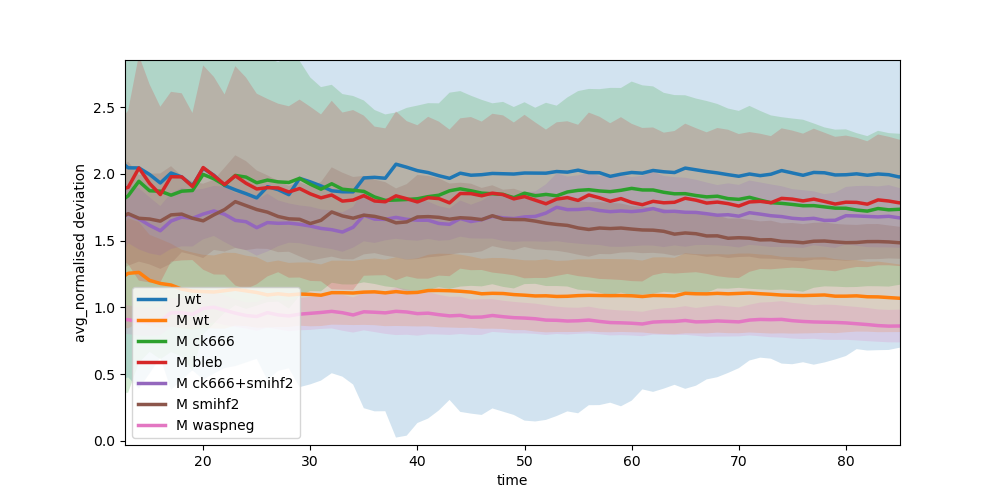

In [22]:
averaged_lists,var = average_lists_by_label(variance_time_store, treatment)
%matplotlib notebook
for (label, averaged_list) ,(label,var) in zip(averaged_lists.items(),var.items()) :
    x = range(len(averaged_list))
    y = np.array(averaged_list)
    error = np.array(var)

    plt.plot(x,y, linewidth=2.5, label=label)
    plt.fill_between(x, y - error, y + error, alpha=0.2)
    #plt.plot(averaged_list, label=label)
    

plt.legend()
plt.xlabel('time')
plt.ylabel('avg_normalised deviation')

plt.show()  